11 앙상블 모델

In [1]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 데이터 준비 및 저장
prepare_and_store_data("data_ml.csv")

# 데이터 가져오기
data_ml = get_data_ml()
training_sample = get_training_sample()
testing_sample = get_testing_sample()
features = get_features()
features_short = get_features_short()

# 결과 확인
print("Data ML Shape:", data_ml.shape)
print("Training Sample Shape:", training_sample.shape)
print("Testing Sample Shape:", testing_sample.shape)
print("Features:", features_short)


Data ML Shape: (536672, 103)
Training Sample Shape: (396256, 103)
Testing Sample Shape: (140416, 103)
Features: ['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']


In [27]:
stock_ids_short = []
stock_days = []
separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

# 패널티 회귀 (chap 5)
from sklearn.linear_model import ElasticNet

y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values
model = ElasticNet(alpha=0.1, l1_ratio=0.1)
fit_pen_pred = model.fit(X_penalized_train, y_penalized_train)

# 단순 트리 (chap 6)
from sklearn import tree
X = data_ml.iloc[:, 3:95]
y = data_ml['R1M_Usd']

fit_tree = tree.DecisionTreeRegressor(
    min_samples_split=8000,
    max_depth= 3,
    ccp_alpha= 0.000001,
    min_samples_leaf= 3500
    )
fit_tree.fit(X, y)

# 랜덤 포레스트 (chap 6)
from sklearn.ensemble import RandomForestRegressor
fit_RF = RandomForestRegressor(n_estimators= 40,
                               criterion='squared_error',
                               min_samples_split=250,
                               bootstrap=True,
                               max_features=30,
                               max_samples=10000
                               )
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

fit_RF.fit(X_train, y_train)

# xgboost (chap 6)
import xgboost as xgb
mono_const="(0, 0, -1, 1, 0, -1, 0)"
train_matrix_xgb = xgb.DMatrix(X_train, y_train)
params={'eta':0.3, #학습률
        'objective':"reg:squarederror", #목적함수 
        'max_depth':4, #트리의 최고 깊이
        'subsample':0.6, #샘플 중 무작위적으로 60%를 선택해 훈련
        'colsample_bytree':0.7, #예측 인자 중 무작위적으로 70%를 선택해 훈련
        'lambda':1, #나뭇잎 값에 대한 규제화
        'gamma':0.1, #나뭇잎 개수에 대한 규제화
        'nrounds':30, #사용한 트리 개수
        'monotone_constraints':mono_const, #단조성 제약 조건
        'rate_drop':0.1, #DART를 위한 드롭률
        'verbose':0} #메시지 없음
fit_xgb = xgb.train(params, train_matrix_xgb)

# 피드백포워드 신경망 (chap 7)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from plot_keras_history import show_history, plot_history


NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['R1M_Usd'].values

model = keras.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(len(features),)))
model.add(layers.Dense(8,activation="tanh"))
model.add(layers.Dense(1))
def custom_loss(y_true, y_pred):
    loss = tf.reduce_mean(
        tf.square(y_pred - tf.reduce_mean(y_pred))) -5 * tf.reduce_mean(
        (y_true - tf.reduce_mean(y_true)) * (y_pred - tf.reduce_mean(y_pred)))
    return loss

model.compile(optimizer='RMSprop',
              loss=custom_loss,
              metrics=['MeanAbsoluteError'])
model.summary()

fit_NN = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_data=(NN_test_features,NN_test_labels),
    verbose=False
)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "nrounds", "rate_drop", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │         1,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25636\2355238988.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  returns = data_ml_unique[is_stock_ids_short].pivot(
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


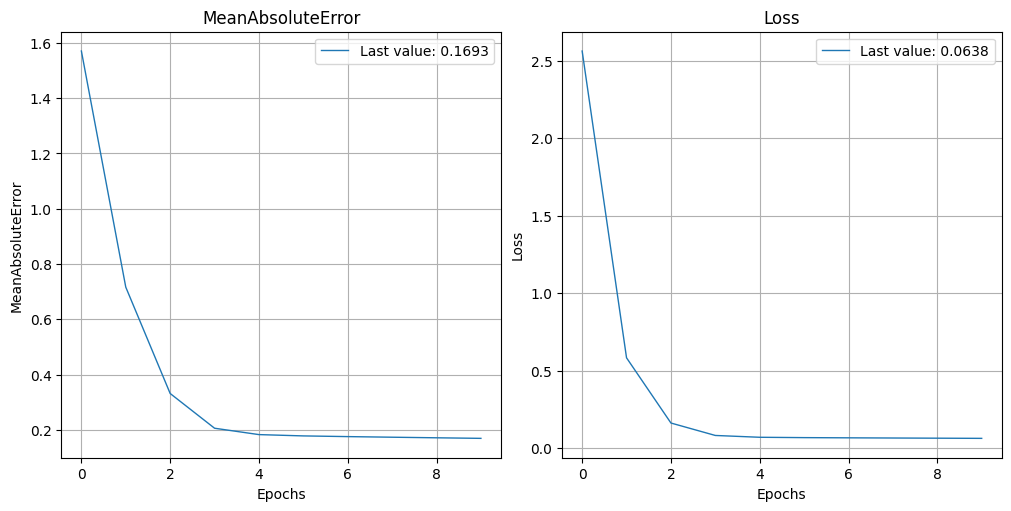

In [34]:
stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
data_ml_unique = data_ml[is_stock_ids_short].drop_duplicates(subset=['date', 'stock_id'])


returns = data_ml_unique[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

data_rnn = data_ml[data_ml['stock_id'].isin(stock_ids_short)]
training_sample_rnn = data_rnn[data_rnn['date']<separation_date]
testing_sample_rnn = data_rnn[data_rnn['date']>separation_date]

nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = training_sample_rnn.shape[0] // nb_stocks
nb_dates_test = testing_sample_rnn.shape[0] // nb_stocks

nn_train_features = training_sample_rnn[features].values
nn_test_features = testing_sample_rnn[features].values
nn_train_labels = training_sample_rnn['R1M_Usd'].values
nn_test_labels = testing_sample_rnn['R1M_Usd'].values

# 데이터 변환: nn_train_features를 (nb_dates_train, nb_stocks, nb_feats) 형식으로 재구성
train_features_rnn = np.reshape(nn_train_features, (nb_dates_train, nb_stocks, nb_feats))
test_features_rnn = np.reshape(nn_test_features, (nb_dates_test, nb_stocks, nb_feats))

# GRU에 맞게 배치 차원으로 변환: (nb_stocks, nb_dates_train, nb_feats)
train_features_rnn = train_features_rnn.transpose(1, 0, 2)  # 
test_features_rnn = test_features_rnn.transpose(1, 0, 2)  # 

# 레이블도 동일한 형식으로 변환
train_labels_rnn = np.reshape(nn_train_labels, (nb_stocks, nb_dates_train, 1))
test_labels_rnn = np.reshape(nn_test_labels, (nb_stocks, nb_dates_test, 1))

model_RNN = keras.Sequential()
model_RNN.add(layers.GRU(16, input_shape= (nb_dates_train, nb_feats),
                         activation='tanh',
                         return_sequences=True))
model_RNN.add(layers.Dense(1))
model_RNN.compile(optimizer='RMSprop', #손실 = 이차
                  loss='mse', # 역전파
                  metrics=['MeanAbsoluteError'])

fit_RNN = model_RNN.fit(train_features_rnn,
                        train_labels_rnn,
                        epochs = 10,
                        batch_size = nb_stocks,
                        verbose=False)
show_history(fit_RNN)

In [39]:
err_pen_train = fit_pen_pred.predict(
    X_penalized_train) - training_sample['R1M_Usd'] #회귀
err_tree_train = fit_tree.predict(
    training_sample[features]) - training_sample['R1M_Usd'] #트리
err_RF_train = fit_RF.predict(
    training_sample[features]) - training_sample['R1M_Usd'] # 랜덤 포레스트
err_XGB_train = fit_xgb.predict(
    train_matrix_xgb) - training_sample['R1M_Usd'] # XGBoost
err_NN_train = model_RNN.predict(
    training_sample[features_short]) - training_sample['R1M_Usd'].values.reshape((-1,1)) # 신경망

E = pd.concat(
    [err_pen_train, err_tree_train, err_RF_train, err_XGB_train, pd.DataFrame(err_NN_train)], axis=1)
E = E.set_axis(['Pen_reg', 'Tree', 'RF', 'XGB', 'NN'], axis=1)
E.corr()

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 7), dtype=float32). Expected shape (None, 336, 92), but input has incompatible shape (32, 7)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 7), dtype=float32)
  • training=False
  • mask=None

In [29]:
E.corr().mean()

Pen_reg    0.793686
Tree       0.794126
RF         0.793628
XGB        0.785535
NN         0.198800
dtype: float64

In [20]:
abs(E).mean()

Pen_reg    0.083459
Tree       0.083668
RF         0.083380
XGB        0.083370
NN         0.084505
dtype: float64

In [23]:
w_ensemble = np.linalg.inv((E.T.values@E.values))@np.ones(5)
#w_ensemble /= np.sum(w_ensemble)
#w_ensemble